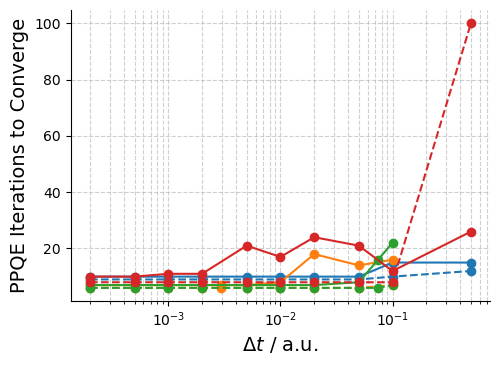

Saved figure as figures/dt_vs_niter_multi.pdf


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import glob
import re

# --- User options ---
use_logx = True
use_logy = False

xlabel = r"$\Delta t$ / a.u."
ylabel = r"PPQE Iterations to Converge"
title = r"Iterations vs. Time Step"

# --- Toggle which systems to plot ---
plot_h8   = True
plot_h2o  = True
plot_h2be = True
plot_c6h6   = True

# --- System setup ---
all_systems = [
    ('h8',   'tab:blue',   'H$_8$'),
    ('h2o',  'tab:orange', 'H$_2$O'),
    ('h2be', 'tab:green',  'H$_2$Be'),
    ('c6h6',   'tab:red',    'C$_6$H$_6$')
]
toggles = [plot_h8, plot_h2o, plot_h2be, plot_c6h6]

system_strings = [s for s, c, l in all_systems if toggles[all_systems.index((s, c, l))]]
system_colors  = [c for s, c, l in all_systems if toggles[all_systems.index((s, c, l))]]
system_labels  = {s: l for s, c, l in all_systems if toggles[all_systems.index((s, c, l))]}

update_types = {'jl': 'solid', 'tlr': 'dashed'}
update_labels = {'jl': 'Jacobi-like', 'tlr': 'Two-level rotation'}

plt.figure(figsize=(5.1, 3.75))

for sys_str, color in zip(system_strings, system_colors):
    for update_str, linestyle in update_types.items():
        pattern = f"ppqe_{sys_str}_dt_*_pool_SD_etol_1.000e-08_ndiis_12_updt_{update_str}_tord_inf.dat"
        summary_files = sorted(glob.glob(pattern))
        dt_list = []
        niter_list = []
        dt_pattern = re.compile(r"dt_([0-9.eE+-]+)_")
        for fname in summary_files:
            m = dt_pattern.search(fname)
            if not m:
                continue
            dt = float(m.group(1))
            with open(fname, "r") as f:
                lines = f.readlines()
            data_lines = [line for line in lines[1:] if not line.strip().startswith("#") and line.strip()]
            if not data_lines:
                continue
            arr = np.loadtxt(data_lines)
            if arr.ndim == 1:
                arr = arr[np.newaxis, :]
            dt_list.append(dt)
            niter_list.append(arr.shape[0])
        if dt_list:
            dt_arr = np.array(dt_list)
            niter_arr = np.array(niter_list)
            sort_idx = np.argsort(dt_arr)
            dt_arr = dt_arr[sort_idx]
            niter_arr = niter_arr[sort_idx]
            label = f"{system_labels.get(sys_str, sys_str)} ({update_labels[update_str]})"
            plt.plot(dt_arr, niter_arr, marker='o', color=color, linestyle=linestyle, label=label)

if use_logx:
    plt.xscale('log')
if use_logy:
    plt.yscale('log')

plt.xlabel(xlabel, fontsize=14)
plt.ylabel(ylabel, fontsize=14)
# plt.title(title, fontsize=15)

plt.grid(True, which='both', ls='--', alpha=0.6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
# plt.legend(fontsize=11)

output_pdf = "figures/dt_vs_niter_multi.pdf"
plt.savefig(output_pdf)
plt.show()
print(f"Saved figure as {output_pdf}")

{'h8': -4.3360656518, 'h2o': -75.599306808, 'h2be': -15.6506872611, 'c6h6': -230.7911477999}


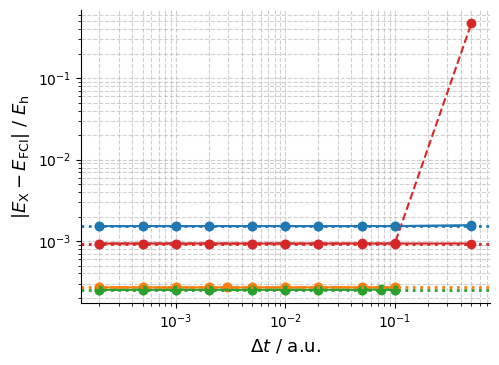

In [14]:
# Make plot of exact time step vs. Energy error for all systems (put Evqe as a reference line)
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

# --- User options: plot all four molecules, only tord='inf' ---
all_systems = [
    ('h8',   'tab:blue',   'H$_8$'),
    ('h2o',  'tab:orange', 'H$_2$O'),
    ('h2be', 'tab:green',  'H$_2$Be'),
    ('c6h6', 'tab:red',    'C$_6$H$_6$'),
]

update_types = {'jl': 'solid', 'tlr': 'dashed'}
update_labels = {'jl': 'Jacobi-like', 'tlr': 'Two-level rotation'}

plt.figure(figsize=(5.1, 3.75))

fci_energies = {}

for sys_str, color, label in all_systems:
    for update_str, linestyle in update_types.items():
        pattern = f"ppqe_{sys_str}_dt_*_pool_SD_etol_1.000e-08_ndiis_12_updt_{update_str}_tord_inf.dat"
        # pattern = f"ppqe_{sys_str}_dt_*_inv_hnrm_false_pool_SD_etol_1.000e-08_ndiis_12_updt_{update_str}_tord_inf.dat"
        summary_files = sorted(glob.glob(pattern))
        dt_list = []
        err_list = []
        dt_pattern = re.compile(r"dt_([0-9.eE+-]+)_")
        for fname in summary_files:
            m = dt_pattern.search(fname)
            if not m:
                continue
            dt = float(m.group(1))
            with open(fname, "r") as f:
                lines = f.readlines()
            header_line = lines[0]
            fci_match = re.search(r'#Efci:\s*([+-]?\d+\.\d+)', header_line)
            if not fci_match:
                continue
            fci_energy = float(fci_match.group(1))
            data_lines = [line for line in lines[1:] if not line.strip().startswith("#") and line.strip()]
            if not data_lines:
                continue
            arr = np.loadtxt(data_lines)
            if arr.ndim == 1:
                arr = arr[np.newaxis, :]
            energy = arr[:, 1]
            abs_error = np.abs(energy[-1] - fci_energy)  # error at convergence
            dt_list.append(dt)
            err_list.append(abs_error)

            fci_energies[sys_str] = fci_energy  # Collect FCI energies for reference
        if dt_list:
            dt_arr = np.array(dt_list)
            err_arr = np.array(err_list)
            sort_idx = np.argsort(dt_arr)
            dt_arr = dt_arr[sort_idx]
            err_arr = err_arr[sort_idx]
            plot_label = f"{label} ({update_labels[update_str]})"
            plt.plot(dt_arr, err_arr, marker='o', color=color, linestyle=linestyle, label=plot_label)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\Delta t$ / a.u.", fontsize=13)
plt.ylabel(r"$|E_\mathrm{X} - E_\mathrm{FCI}| ~/ ~E_\mathrm{h}$", fontsize=13)
plt.grid(True, which='both', ls='--', alpha=0.6)

Evqe_h8 = -4.3345371732
Evqe_h2o = -75.5990364855
Evqe_h2be = -15.6504350047
Evqe_c6h6 = -230.7902138051

print(fci_energies)


# Example horizontal lines
hlines = [
    (np.abs(fci_energies['h8'] - Evqe_h8 ), 'tab:blue', 'Threshold 1e-3'),
    (np.abs(fci_energies['h2o'] - Evqe_h2o), 'tab:orange',  'Threshold 1e-4'),
    (np.abs(fci_energies['h2be'] -  Evqe_h2be), 'tab:green',  'Threshold 1e-4'),
    (np.abs(fci_energies['c6h6'] - Evqe_c6h6), 'tab:red',  'Threshold 1e-4')
]

for y, color, label in hlines:
    plt.axhline(y, color=color, linestyle=':', linewidth=2, label=label)

# plt.legend(fontsize=10)
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
output_pdf = "figures/dt_vs_Eppqe_multisys.pdf"
plt.savefig(output_pdf)

plt.show()

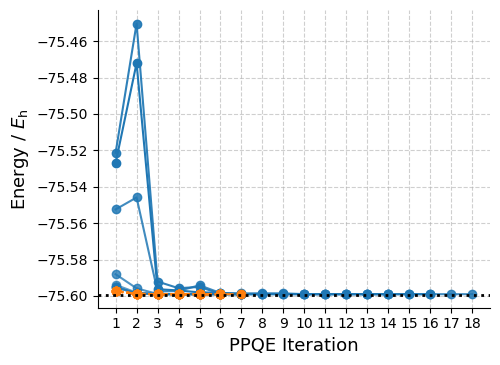

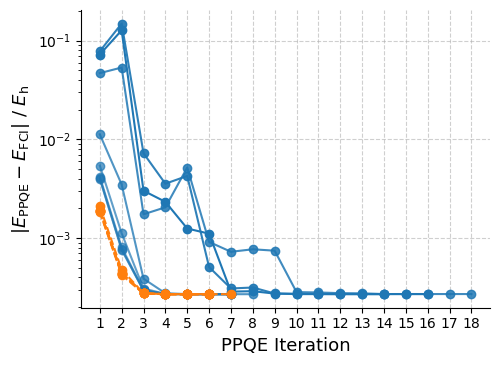

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

# --- User options: select only one molecule to plot ---
plot_h8   = False
plot_h2o  = True
plot_h2be = False
plot_c6h6 = False

# --- Optional: horizontal line for error (set to None to disable) ---
hline_error = None  # e.g., 1e-5 for a line at error 1e-5, or None for no line

# --- System setup ---
all_systems = [
    ('h8',   'tab:blue',   'H$_8$'),
    ('h2o',  'tab:orange', 'H$_2$O'),
    ('h2be', 'tab:green',  'H$_2$Be'),
    ('c6h6', 'tab:red',    'C$_6$H$_6$'),
]
toggles = [plot_h8, plot_h2o, plot_h2be, plot_c6h6]

# Only one system should be selected
if sum(toggles) != 1:
    raise ValueError("Please select exactly one molecule to plot by setting its toggle to True.")

system_idx = toggles.index(True)
sys_str, _, label = all_systems[system_idx]

# --- Color and style for update types ---
update_types = {
    'jl': {'color': 'tab:blue', 'linestyle': 'solid', 'label': 'Jacobi-like'},
    'tlr': {'color': 'tab:orange', 'linestyle': 'dashed', 'label': 'Two-level rotation'}
}

# --- Plot Absolute Energy ---
plt.figure(figsize=(5.1, 3.75))
max_iter = 0
fci_energy_found = None  # Will be set to the FCI energy from the first file found

for update_str, props in update_types.items():
    pattern = f"ppqe_{sys_str}_dt_*_inv_hnrm_false_pool_SD_etol_1.000e-08_ndiis_12_updt_{update_str}_tord_inf.dat"
    summary_files = sorted(glob.glob(pattern))
    # Sort files by dt value
    dt_pattern = re.compile(r"dt_([0-9.eE+-]+)_")
    dt_files = []
    for fname in summary_files:
        m = dt_pattern.search(fname)
        if m:
            dt_files.append((float(m.group(1)), fname))
    dt_files.sort()
    n_files = len(dt_files)
    for i, (dt, fname) in enumerate(dt_files):
        alpha = 0.4 + 0.6 * (i / max(n_files-1, 1))  # More opaque for larger dt
        with open(fname, "r") as f:
            lines = f.readlines()
        header_line = lines[0]
        fci_match = re.search(r'#Efci:\s*([+-]?\d+\.\d+)', header_line)
        if not fci_match:
            continue
        fci_energy = float(fci_match.group(1))
        if fci_energy_found is None:
            fci_energy_found = fci_energy  # Save for hline
        data_lines = [line for line in lines[1:] if not line.strip().startswith("#") and line.strip()]
        if not data_lines:
            continue
        arr = np.loadtxt(data_lines)
        if arr.ndim == 1:
            arr = arr[np.newaxis, :]
        energy = arr[:, 1]
        iterations = np.arange(1, len(energy) + 1)
        max_iter = max(max_iter, iterations[-1])
        # Only label the first line for each update type
        plot_label = f"{label} ({props['label']})" if i == 0 else None
        plt.plot(iterations, energy, marker='o', color=props['color'], linestyle=props['linestyle'],
                 alpha=alpha, label=plot_label)
# Set x-ticks to spread out and avoid overlap
if max_iter > 20:
    step = max(1, max_iter // 10)
else:
    step = 1
plt.xticks(np.arange(1, max_iter + 1, step))
plt.xlabel("PPQE Iteration", fontsize=13)
plt.ylabel("Energy$~/ ~E_\mathrm{h}$", fontsize=13)
plt.grid(True, ls='--', alpha=0.6)
if fci_energy_found is not None:
    plt.axhline(fci_energy_found, color='k', linestyle=':', linewidth=2, label='FCI Energy')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
# plt.legend(fontsize=11)

output_pdf = f"figures/E_vs_niter_{sys_str}.pdf"
plt.savefig(output_pdf)

plt.show()

# --- Plot Absolute Energy Error ---
plt.figure(figsize=(5.1, 3.75))
max_iter = 0
for update_str, props in update_types.items():
    pattern = f"ppqe_{sys_str}_dt_*_inv_hnrm_false_pool_SD_etol_1.000e-08_ndiis_12_updt_{update_str}_tord_inf.dat"
    summary_files = sorted(glob.glob(pattern))
    dt_pattern = re.compile(r"dt_([0-9.eE+-]+)_")
    dt_files = []
    for fname in summary_files:
        m = dt_pattern.search(fname)
        if m:
            dt_files.append((float(m.group(1)), fname))
    dt_files.sort()
    n_files = len(dt_files)
    for i, (dt, fname) in enumerate(dt_files):
        alpha = 0.4 + 0.6 * (i / max(n_files-1, 1))
        with open(fname, "r") as f:
            lines = f.readlines()
        header_line = lines[0]
        fci_match = re.search(r'#Efci:\s*([+-]?\d+\.\d+)', header_line)
        if not fci_match:
            continue
        fci_energy = float(fci_match.group(1))
        data_lines = [line for line in lines[1:] if not line.strip().startswith("#") and line.strip()]
        if not data_lines:
            continue
        arr = np.loadtxt(data_lines)
        if arr.ndim == 1:
            arr = arr[np.newaxis, :]
        energy = arr[:, 1]
        iterations = np.arange(1, len(energy) + 1)
        max_iter = max(max_iter, iterations[-1])
        abs_error = np.abs(energy - fci_energy)
        plot_label = f"{label} ({props['label']})" if i == 0 else None
        plt.plot(iterations, abs_error, marker='o', color=props['color'], linestyle=props['linestyle'],
                 alpha=alpha, label=plot_label)
# Set x-ticks to spread out and avoid overlap
if max_iter > 20:
    step = max(1, max_iter // 10)
else:
    step = 1
plt.xticks(np.arange(1, max_iter + 1, step))
plt.xlabel("PPQE Iteration", fontsize=13)
plt.ylabel(r"$|E_\mathrm{PPQE} - E_\mathrm{FCI}| ~/ ~E_\mathrm{h}$", fontsize=13)
plt.yscale('log')
plt.grid(True, ls='--', alpha=0.6)
if hline_error is not None:
    plt.axhline(hline_error, color='k', linestyle=':', linewidth=2, label='Error Threshold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
output_pdf = f"figures/dE_vs_niter_{sys_str}.pdf"
plt.savefig(output_pdf)
# plt.legend(fontsize=11)
plt.show()

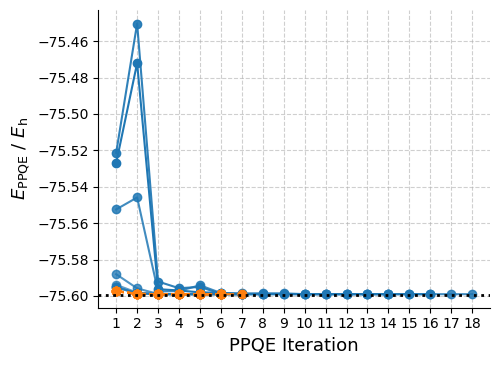

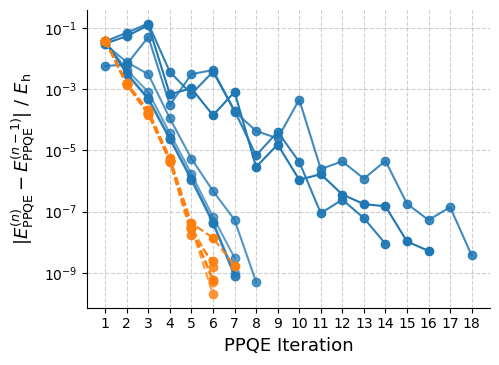

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

# --- User options: select only one molecule to plot ---
plot_h8   = False
plot_h2o  = True
plot_h2be = False
plot_c6h6 = False

# --- Optional: horizontal line for error (set to None to disable) ---
hline_error = None  # e.g., 1e-5 for a line at error 1e-5, or None for no line

# --- System setup ---
all_systems = [
    ('h8',   'tab:blue',   'H$_8$'),
    ('h2o',  'tab:orange', 'H$_2$O'),
    ('h2be', 'tab:green',  'H$_2$Be'),
    ('c6h6', 'tab:red',    'C$_6$H$_6$'),
]
toggles = [plot_h8, plot_h2o, plot_h2be, plot_c6h6]

# Only one system should be selected
if sum(toggles) != 1:
    raise ValueError("Please select exactly one molecule to plot by setting its toggle to True.")

system_idx = toggles.index(True)
sys_str, _, label = all_systems[system_idx]

# --- Color and style for update types ---
update_types = {
    'jl': {'color': 'tab:blue', 'linestyle': 'solid', 'label': 'Jacobi-like'},
    'tlr': {'color': 'tab:orange', 'linestyle': 'dashed', 'label': 'Two-level rotation'}
}

# --- Plot Absolute Energy ---
plt.figure(figsize=(5.1, 3.75))
max_iter = 0
fci_energy_found = None  # Will be set to the FCI energy from the first file found

for update_str, props in update_types.items():
    pattern = f"ppqe_{sys_str}_dt_*_inv_hnrm_false_pool_SD_etol_1.000e-08_ndiis_12_updt_{update_str}_tord_inf.dat"
    summary_files = sorted(glob.glob(pattern))
    # Sort files by dt value
    dt_pattern = re.compile(r"dt_([0-9.eE+-]+)_")
    dt_files = []
    for fname in summary_files:
        m = dt_pattern.search(fname)
        if m:
            dt_files.append((float(m.group(1)), fname))
    dt_files.sort()
    n_files = len(dt_files)
    for i, (dt, fname) in enumerate(dt_files):
        alpha = 0.4 + 0.6 * (i / max(n_files-1, 1))  # More opaque for larger dt
        with open(fname, "r") as f:
            lines = f.readlines()
        header_line = lines[0]
        fci_match = re.search(r'#Efci:\s*([+-]?\d+\.\d+)', header_line)
        if not fci_match:
            continue
        fci_energy = float(fci_match.group(1))
        if fci_energy_found is None:
            fci_energy_found = fci_energy  # Save for hline
        data_lines = [line for line in lines[1:] if not line.strip().startswith("#") and line.strip()]
        if not data_lines:
            continue
        arr = np.loadtxt(data_lines)
        if arr.ndim == 1:
            arr = arr[np.newaxis, :]
        energy = arr[:, 1]
        iterations = np.arange(1, len(energy) + 1)
        max_iter = max(max_iter, iterations[-1])
        # Only label the first line for each update type
        plot_label = f"{label} ({props['label']})" if i == 0 else None
        plt.plot(iterations, energy, marker='o', color=props['color'], linestyle=props['linestyle'],
                 alpha=alpha, label=plot_label)
# Set x-ticks to spread out and avoid overlap
if max_iter > 20:
    step = max(1, max_iter // 10)
else:
    step = 1
plt.xticks(np.arange(1, max_iter + 1, step))
plt.xlabel("PPQE Iteration", fontsize=13)
plt.ylabel("$E_\mathrm{PPQE} ~/ ~E_\mathrm{h}$", fontsize=13)
plt.grid(True, ls='--', alpha=0.6)
if fci_energy_found is not None:
    plt.axhline(fci_energy_found, color='k', linestyle=':', linewidth=2, label='FCI Energy')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
# plt.legend(fontsize=11)

output_pdf = f"figures/E_vs_niter_{sys_str}.pdf"
plt.savefig(output_pdf)

plt.show()

# --- Plot Absolute Energy Difference (from 3rd column) ---
plt.figure(figsize=(5.1, 3.75))
max_iter = 0
for update_str, props in update_types.items():
    pattern = f"ppqe_{sys_str}_dt_*_inv_hnrm_false_pool_SD_etol_1.000e-08_ndiis_12_updt_{update_str}_tord_inf.dat"
    summary_files = sorted(glob.glob(pattern))
    dt_pattern = re.compile(r"dt_([0-9.eE+-]+)_")
    dt_files = []
    for fname in summary_files:
        m = dt_pattern.search(fname)
        if m:
            dt_files.append((float(m.group(1)), fname))
    dt_files.sort()
    n_files = len(dt_files)
    for i, (dt, fname) in enumerate(dt_files):
        alpha = 0.4 + 0.6 * (i / max(n_files-1, 1))
        with open(fname, "r") as f:
            lines = f.readlines()
        data_lines = [line for line in lines[1:] if not line.strip().startswith("#") and line.strip()]
        if not data_lines:
            continue
        arr = np.loadtxt(data_lines)
        if arr.ndim == 1:
            arr = arr[np.newaxis, :]
        # 3rd column is the energy difference at each iteration
        energy_diff = np.abs(arr[:, 2])
        iterations = np.arange(1, len(energy_diff) + 1)
        max_iter = max(max_iter, iterations[-1])
        plot_label = f"{label} ({props['label']})" if i == 0 else None
        plt.plot(iterations, energy_diff, marker='o', color=props['color'], linestyle=props['linestyle'],
                 alpha=alpha, label=plot_label)

# Set x-ticks to spread out and avoid overlap
if max_iter > 20:
    step = max(1, max_iter // 10)
else:
    step = 1
plt.xticks(np.arange(1, max_iter + 1, step))
plt.xlabel("PPQE Iteration", fontsize=13)
plt.ylabel(r"$|E_\mathrm{PPQE}^{(n)} - E_\mathrm{PPQE}^{(n-1)}| ~/ ~E_\mathrm{h}$", fontsize=13)
plt.yscale('log')
plt.grid(True, ls='--', alpha=0.6)
if hline_error is not None:
    plt.axhline(hline_error, color='k', linestyle=':', linewidth=2, label='Error Threshold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
output_pdf = f"figures/dE_iter_vs_niter_{sys_str}.pdf"
plt.savefig(output_pdf)
# plt.legend(fontsize=11)
plt.show()

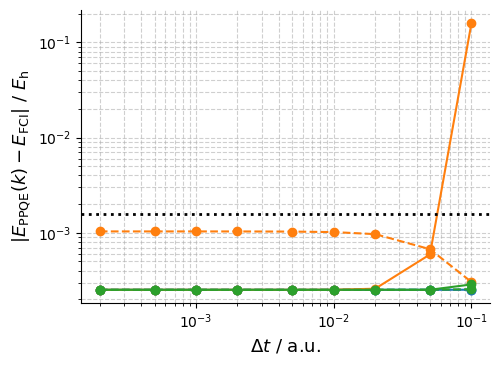

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

# --- User options: select only one molecule to plot ---
plot_h8   = False
plot_h2o  = False  # Do this one
plot_h2be = True
plot_c6h6 = False # And this one

# --- System setup ---
all_systems = [
    ('h8',   'tab:blue',   'H$_8$'),
    ('h2o',  'tab:orange', 'H$_2$O'),
    ('h2be', 'tab:green',  'H$_2$Be'),
    ('c6h6', 'tab:red',    'C$_6$H$_6$'),
]
toggles = [plot_h8, plot_h2o, plot_h2be, plot_c6h6]
if sum(toggles) != 1:
    raise ValueError("Please select exactly one molecule to plot by setting its toggle to True.")
system_idx = toggles.index(True)
sys_str, base_color, label = all_systems[system_idx]

update_types = {'jl': 'solid', 'tlr': 'dashed'}
update_labels = {'jl': 'Jacobi-like', 'tlr': 'Two-level rotation'}

tord_options = ['inf', '1', '2']
tord_colors = {'inf': 'tab:blue', '1': 'tab:orange', '2': 'tab:green'}
tord_labels = {'inf': r'$t_\mathrm{ord} = \infty$', '1': r'$t_\mathrm{ord} = 1$', '2': r'$t_\mathrm{ord} = 2$'}

plt.figure(figsize=(5.1, 3.75))

for tord in tord_options:
    for update_str, linestyle in update_types.items():
        pattern = f"ppqe_{sys_str}_dt_*_inv_hnrm_false_pool_SD_etol_1.000e-08_ndiis_12_updt_{update_str}_tord_{tord}.dat"
        summary_files = sorted(glob.glob(pattern))
        dt_list = []
        err_list = []
        dt_pattern = re.compile(r"dt_([0-9.eE+-]+)_")
        for fname in summary_files:
            m = dt_pattern.search(fname)
            if not m:
                continue
            dt = float(m.group(1))
            with open(fname, "r") as f:
                lines = f.readlines()
            header_line = lines[0]
            fci_match = re.search(r'#Efci:\s*([+-]?\d+\.\d+)', header_line)
            if not fci_match:
                continue
            fci_energy = float(fci_match.group(1))
            data_lines = [line for line in lines[1:] if not line.strip().startswith("#") and line.strip()]
            if not data_lines:
                continue
            arr = np.loadtxt(data_lines)
            if arr.ndim == 1:
                arr = arr[np.newaxis, :]
            energy = arr[:, 1]
            abs_error = np.abs(energy[-1] - fci_energy)  # error at convergence
            dt_list.append(dt)
            err_list.append(abs_error)
        if dt_list:
            dt_arr = np.array(dt_list)
            err_arr = np.array(err_list)
            sort_idx = np.argsort(dt_arr)
            dt_arr = dt_arr[sort_idx]
            err_arr = err_arr[sort_idx]
            plot_label = f"{label} {tord_labels[tord]} ({update_labels[update_str]})"
            plt.plot(dt_arr, err_arr, marker='o', color=tord_colors[tord], linestyle=linestyle, label=plot_label)

plt.axhline(1.59e-3, color='black', linestyle=':', linewidth=2, label='1kcal/mol')  
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\Delta t$ / a.u.", fontsize=13)
plt.ylabel(r"$|E_\mathrm{PPQE}(k) - E_\mathrm{FCI}| ~/ ~E_\mathrm{h}$", fontsize=13)
plt.grid(True, which='both', ls='--', alpha=0.6)

# plt.legend(fontsize=10)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

output_pdf = f"figures/dEfci_vs_dt_{sys_str}.pdf"
plt.savefig(output_pdf)
plt.show()

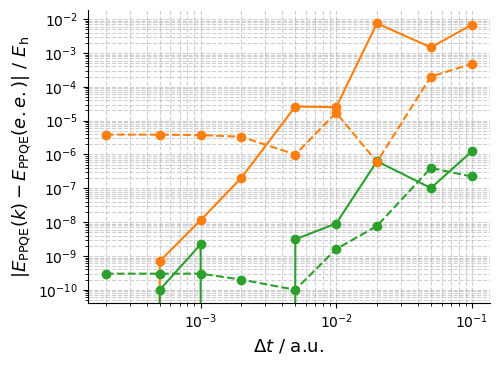

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

# --- User options: select only one molecule to plot ---
plot_h8   = False
plot_h2o  = False
plot_h2be = False
plot_c6h6 = True

# --- System setup ---
all_systems = [
    ('h8',   'tab:blue',   'H$_8$'),
    ('h2o',  'tab:orange', 'H$_2$O'),
    ('h2be', 'tab:green',  'H$_2$Be'),
    ('c6h6', 'tab:red',    'C$_6$H$_6$'),
]
toggles = [plot_h8, plot_h2o, plot_h2be, plot_c6h6]
if sum(toggles) != 1:
    raise ValueError("Please select exactly one molecule to plot by setting its toggle to True.")
system_idx = toggles.index(True)
sys_str, base_color, label = all_systems[system_idx]

# Set color and linestyle for each (update, tord) pair
plot_styles = {
    ('jl', '1'):  {'color': 'tab:orange', 'linestyle': 'solid',  'label': f"{label} Jacobi-like ($t_{{ord}}=1$ vs $t_{{ord}}=\\infty$)"},
    ('jl', '2'):  {'color': 'tab:green',  'linestyle': 'solid',  'label': f"{label} Jacobi-like ($t_{{ord}}=2$ vs $t_{{ord}}=\\infty$)"},
    ('tlr', '1'): {'color': 'tab:orange', 'linestyle': 'dashed', 'label': f"{label} Two-level rotation ($t_{{ord}}=1$ vs $t_{{ord}}=\\infty$)"},
    ('tlr', '2'): {'color': 'tab:green',  'linestyle': 'dashed', 'label': f"{label} Two-level rotation ($t_{{ord}}=2$ vs $t_{{ord}}=\\infty$)"},
}

plt.figure(figsize=(5.1, 3.75))

for update_str in ['jl', 'tlr']:
    # Gather all dt values for which all three tord files exist
    dt_pattern = re.compile(r"dt_([0-9.eE+-]+)_")
    dt_to_energy = {'inf': {}, '1': {}, '2': {}}
    for tord in ['inf', '1', '2']:
        pattern = f"ppqe_{sys_str}_dt_*_inv_hnrm_false_pool_SD_etol_1.000e-08_ndiis_12_updt_{update_str}_tord_{tord}.dat"
        for fname in glob.glob(pattern):
            m = dt_pattern.search(fname)
            if not m:
                continue
            dt = float(m.group(1))
            with open(fname, "r") as f:
                lines = f.readlines()
            data_lines = [line for line in lines[1:] if not line.strip().startswith("#") and line.strip()]
            if not data_lines:
                continue
            arr = np.loadtxt(data_lines)
            if arr.ndim == 1:
                arr = arr[np.newaxis, :]
            energy = arr[-1, 1]  # final energy at convergence
            dt_to_energy[tord][dt] = energy

    # Only keep dt values present for all three tord cases
    common_dt = sorted(set(dt_to_energy['inf']) & set(dt_to_energy['1']) & set(dt_to_energy['2']))
    # Plot error for tord=1 and tord=2 relative to tord=inf
    for tord in ['1', '2']:
        err_list = []
        for dt in common_dt:
            err = np.abs(dt_to_energy[tord][dt] - dt_to_energy['inf'][dt])
            err_list.append(err)
        style = plot_styles[(update_str, tord)]
        plt.plot(common_dt, err_list, marker='o', color=style['color'], linestyle=style['linestyle'], label=style['label'])

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\Delta t$ / a.u.", fontsize=13)
plt.ylabel(r"$|E_\mathrm{PPQE}(k) - E_\mathrm{PPQE}(e.e.)| ~/ ~E_\mathrm{h}$", fontsize=13)
plt.grid(True, which='both', ls='--', alpha=0.6)
# plt.legend(fontsize=10)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

output_pdf = f"figures/dEtrott_vs_dt_{sys_str}.pdf"
plt.savefig(output_pdf)
plt.show()

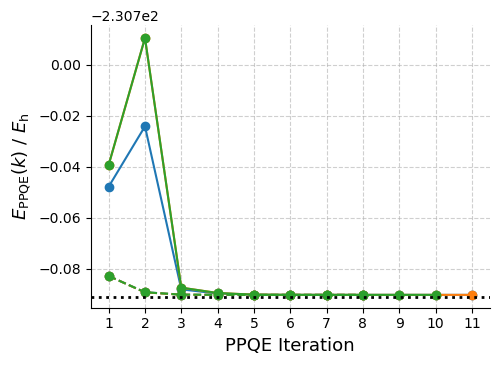

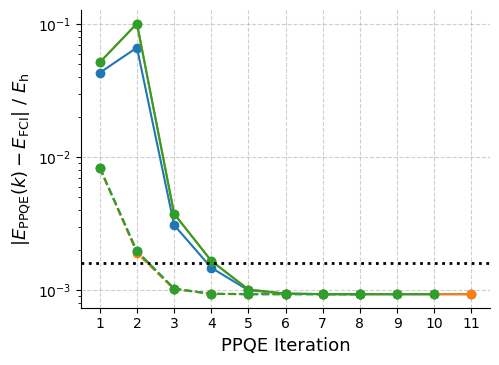

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

# --- User options: select only one molecule and time step to plot ---
plot_h8   = False
plot_h2o  = False
plot_h2be = False
plot_c6h6 = True

plot_dt = "1.000e-03"  # Change this string to plot a different time step
# plot_dt = "2.951e-03"  # Change this string to plot a different time step

# --- Optional: horizontal line for error (set to None to disable) ---
hline_error = None  # e.g., 1e-5 for a line at error 1e-5, or None for no line

# --- System setup ---
all_systems = [
    ('h8',   'tab:blue',   'H$_8$'),
    ('h2o',  'tab:orange', 'H$_2$O'),
    ('h2be', 'tab:green',  'H$_2$Be'),
    ('c6h6', 'tab:red',    'C$_6$H$_6$'),
]
toggles = [plot_h8, plot_h2o, plot_h2be, plot_c6h6]
if sum(toggles) != 1:
    raise ValueError("Please select exactly one molecule to plot by setting its toggle to True.")
system_idx = toggles.index(True)
sys_str, base_color, label = all_systems[system_idx]

update_types = {'jl': 'solid', 'tlr': 'dashed'}
update_labels = {'jl': 'Jacobi-like', 'tlr': 'Two-level rotation'}

# --- tord options and colors ---
tord_options = ['inf', '1', '2']
tord_colors = {'inf': 'tab:blue', '1': 'tab:orange', '2': 'tab:green'}
tord_labels = {'inf': r'$t_\mathrm{ord} = \infty$', '1': r'$t_\mathrm{ord} = 1$', '2': r'$t_\mathrm{ord} = 2$'}

# --- Plot Absolute Energy ---
plt.figure(figsize=(5.1, 3.75))
max_iter = 0
fci_energy_found = None  # Will be set to the FCI energy from the first file found

for tord in tord_options:
    for update_str, linestyle in update_types.items():
        pattern = f"ppqe_{sys_str}_dt_{plot_dt}_inv_hnrm_false_pool_SD_etol_1.000e-08_ndiis_12_updt_{update_str}_tord_{tord}.dat"
        summary_files = sorted(glob.glob(pattern))
        for fname in summary_files:
            with open(fname, "r") as f:
                lines = f.readlines()
            header_line = lines[0]
            fci_match = re.search(r'#Efci:\s*([+-]?\d+\.\d+)', header_line)
            if not fci_match:
                continue
            fci_energy = float(fci_match.group(1))
            if fci_energy_found is None:
                fci_energy_found = fci_energy  # Save for hline
            data_lines = [line for line in lines[1:] if not line.strip().startswith("#") and line.strip()]
            if not data_lines:
                continue
            arr = np.loadtxt(data_lines)
            if arr.ndim == 1:
                arr = arr[np.newaxis, :]
            energy = arr[:, 1]
            iterations = np.arange(1, len(energy) + 1)
            max_iter = max(max_iter, iterations[-1])
            plot_label = f"{label} {tord_labels[tord]} ({update_labels[update_str]})"
            plt.plot(iterations, energy, marker='o', color=tord_colors[tord], linestyle=linestyle, label=plot_label)
# Set x-ticks to spread out and avoid overlap
if max_iter > 20:
    step = max(1, max_iter // 10)
else:
    step = 1
plt.xticks(np.arange(1, max_iter + 1, step))
plt.xlabel("PPQE Iteration", fontsize=13)
plt.ylabel("$E_\mathrm{PPQE}(k) ~/ ~E_\mathrm{h}$", fontsize=13)
plt.grid(True, ls='--', alpha=0.6)
# plt.legend(fontsize=10)
if fci_energy_found is not None:
    plt.axhline(fci_energy_found, color='k', linestyle=':', linewidth=2, label='FCI Energy')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

output_pdf = f"figures/Eppqe_vs_iter_trott_{sys_str}_dt_{plot_dt}.pdf"
plt.savefig(output_pdf)

plt.show()

# --- Plot Absolute Energy Error ---
plt.figure(figsize=(5.1, 3.75))
max_iter = 0
for tord in tord_options:
    for update_str, linestyle in update_types.items():
        pattern = f"ppqe_{sys_str}_dt_{plot_dt}_inv_hnrm_false_pool_SD_etol_1.000e-08_ndiis_12_updt_{update_str}_tord_{tord}.dat"
        summary_files = sorted(glob.glob(pattern))
        for fname in summary_files:
            with open(fname, "r") as f:
                lines = f.readlines()
            header_line = lines[0]
            fci_match = re.search(r'#Efci:\s*([+-]?\d+\.\d+)', header_line)
            if not fci_match:
                continue
            fci_energy = float(fci_match.group(1))
            data_lines = [line for line in lines[1:] if not line.strip().startswith("#") and line.strip()]
            if not data_lines:
                continue
            arr = np.loadtxt(data_lines)
            if arr.ndim == 1:
                arr = arr[np.newaxis, :]
            energy = arr[:, 1]
            iterations = np.arange(1, len(energy) + 1)
            max_iter = max(max_iter, iterations[-1])
            abs_error = np.abs(energy - fci_energy)
            plot_label = f"{label} {tord_labels[tord]} ({update_labels[update_str]})"
            plt.plot(iterations, abs_error, marker='o', color=tord_colors[tord], linestyle=linestyle, label=plot_label)
# Set x-ticks to spread out and avoid overlap
if max_iter > 20:
    step = max(1, max_iter // 10)
else:
    step = 1
plt.xticks(np.arange(1, max_iter + 1, step))
plt.xlabel("PPQE Iteration", fontsize=13)
plt.ylabel(r"$|E_\mathrm{PPQE}(k) - E_\mathrm{FCI}| ~/ ~E_\mathrm{h}$", fontsize=13)
plt.yscale('log')
plt.grid(True, ls='--', alpha=0.6)
plt.axhline(1.59e-3, color='black', linestyle=':', linewidth=2, label='1kcal/mol')  
# plt.legend(fontsize=10)
if hline_error is not None:
    plt.axhline(hline_error, color='k', linestyle=':', linewidth=2, label='Error Threshold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

output_pdf = f"figures/dEppqe_vs_iter_trott_{sys_str}_dt_{plot_dt}.pdf"
plt.savefig(output_pdf)

plt.show()